In [ ]:
!git clone https://github.com/luca-medeiros/lang-segment-anything
%cd lang-segment-anything
!pip install torch torchvision lightning[app]
!pip install -e .

In [ ]:
%cd /content/lang-segment-anything
import os
import warnings

from functools import partial
import lightning as L
import numpy as np
from lightning.app import LightningApp
from lightning.app.components.serve import ServeGradio
from PIL import Image
import requests
import io

from lang_sam import LangSAM
from lang_sam import SAM_MODELS
from lang_sam.utils import draw_image
from lang_sam.utils import load_image

warnings.filterwarnings("ignore")



def load_image_from_url(url):
    response = requests.get(url)
    if response.status_code == 200:
        image_data = io.BytesIO(response.content)
        return Image.open(image_data).convert("RGB")
    else:
        raise Exception(f"Error loading image from {url}")



class Main:
    def __init__(self, sam_type="vit_h"):
        super().__init__()
        self._model = None
        self.ready = False
        self.sam_type = sam_type

    def predict(self, sam_type, box_threshold, text_threshold, text_prompt, img_pil, return_info=False):
        print("Predicting... ", sam_type, box_threshold, text_threshold, img_pil, text_prompt)
        if sam_type != self._model.sam_type:
            self._model.build_sam(sam_type)


        masks, boxes, phrases, logits = self._model.predict(img_pil, text_prompt, box_threshold, text_threshold)
        info = masks, boxes, phrases, logits
        labels = [f"{phrase} {logit:.2f}" for phrase, logit in zip(phrases, logits)]
        image_array = np.asarray(img_pil)
        image = draw_image(image_array, masks, boxes, labels)
        image = Image.fromarray(np.uint8(image)).convert("RGB")
        return image, info

    def build_model(self, sam_type="vit_h"):
        model = LangSAM(sam_type)
        self.ready = True
        return model

    def run(self, *args, **kwargs):
        if self._model is None:
            self._model = self.build_model()
        fn = partial(self.predict, *args, **kwargs)
        fn.__name__ = self.predict.__name__
        self.ready = True
        return fn


model = Main().run()
sam_type = "vit_h"
box_threshold = 0.3
text_threshold = 0.25
text_prompt = "people"

### Dataset

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
import numpy as np


def load_lfw_dataset(min_faces_per_person=2, resize=0.4):
    """
    Loads the LFW dataset.

    :param min_faces_per_person: The minimum number of faces to consider for each person.
    :param resize: The factor to resize the images by.
    :return: The dataset containing images and labels.
    """
    # Fetch the dataset
    lfw_people = fetch_lfw_people(min_faces_per_person=min_faces_per_person, resize=resize, color=True)

    # Information about the dataset
    n_samples, h, w, c = lfw_people.images.shape
    X = lfw_people.data
    n_features = X.shape[1]
    y = lfw_people.target
    target_names = lfw_people.target_names
    n_classes = target_names.shape[0]

    print(f"Total dataset size:")
    print(f"n_samples: {n_samples}")
    print(f"n_features: {n_features}")
    print(f"n_classes: {n_classes}")

    return lfw_people, h, w, c


# Load the dataset
lfw_people, h, w, c = load_lfw_dataset(resize=1.0)

X = lfw_people.data
labels = lfw_people.target_names[lfw_people.target]
X = X.reshape(-1, h, w, c)
X.shape

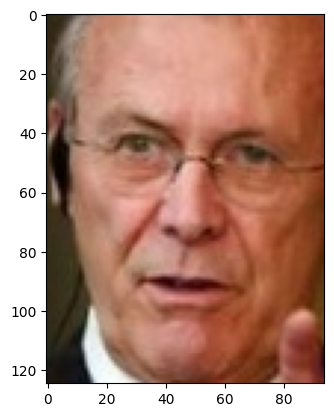

In [ ]:
plt.imshow(X[2, :, :, :])

In [ ]:
list(lfw_people.target_names[300:])

In [ ]:
selected_names = [
    'Nicole Kidman',
    'Madonna',
    'Britney Spears',
    'Keanu Reeves',
    'Prince William',
    'Keira Knightley',
    'Angelina Jolie',
    'Laura Bush',
    'Salma Hayek',
    'Matt Damon',
    'Abdullah Gul',
    'Paul Burrell',
    'Ann Veneman',
    'Jennifer Lopez',
    'Jennifer Aniston',
    'Michael Jackson',
    'Orlando Bloom',
    'Nicolas Cage',
    'Mick Jagger'
]
idxs = np.isin(labels, selected_names)
X_selected = X[idxs]
labels_selected = labels[idxs]

In [ ]:
import numpy as np
from PIL import Image
from matplotlib import cm


def image_from_array(img):
  return Image.fromarray(np.uint8((img)*255)).convert("RGB")


def concatenate_images(array, padding=0):
    # Ensure the array is a 4D NumPy array
    if not isinstance(array, np.ndarray) or len(array.shape) != 4:
        raise ValueError("Input must be a 4D NumPy array")

    k_squared, height, width, channels = array.shape
    k = int(np.sqrt(k_squared))

    # Ensure k is a perfect square
    if k * k != k_squared:
        raise ValueError("The first dimension of the array must be a perfect square")

    padded_width = width + 2 * padding
    padded_height = height + 2 * padding

    # Create a new blank image to hold the concatenation with padding
    concatenated_image = Image.new('RGB', (k * padded_width, k * padded_height))

    # Create and paste each padded image into the concatenated image
    for i in range(k_squared):
        img = image_from_array(array[i])

        # Add padding
        padded_img = Image.new('RGB', (padded_width, padded_height), color='black')
        padded_img.paste(img, (padding, padding))

        x = (i % k) * padded_width
        y = (i // k) * padded_height
        concatenated_image.paste(padded_img, (x, y))

    return concatenated_image



def sample_images(X, labels, unique_labels, k=3):
    # Step 1: Randomly select k*k distinct labels from unique_labels
    selected_labels = np.random.choice(unique_labels, size=k*k, replace=False)

    X_sample = []
    labels_sample = []

    # Step 2: For each selected label, randomly choose one image that corresponds to that label
    for label in selected_labels:
        # Find indices of all images with the current label
        idxs = np.where(labels == label)[0]

        # Randomly select one index and use it to get the corresponding image and label
        selected_idx = np.random.choice(idxs)
        X_sample.append(X[selected_idx])
        labels_sample.append(labels[selected_idx])

    # Convert X_sample to a numpy array
    X_sample = np.array(X_sample)

    # Concatenate images (assuming concatenate_images is a predefined function)
    concat_img = concatenate_images(X_sample, padding=3)
    return X_sample, labels_sample


X_sample, labels_sample = sample_images(X_selected, labels_selected, selected_names, k=3)
labels_sample

In [ ]:
class EvaluationMetrics:
    def __init__(self, tp=0, fp=0, fn=0, tn=0, error_count=0):
        self.tp = tp
        self.fp = fp
        self.fn = fn
        self.tn = tn
        self.error_count = error_count

    def __add__(self, other):
        """
        Enable addition using the '+' operator.
        """
        if not isinstance(other, EvaluationMetrics):
            return NotImplemented
        return EvaluationMetrics(self.tp + other.tp, self.fp + other.fp,
                                 self.fn + other.fn, self.tn + other.tn)

    def precision(self):
        """
        Calculate and return the precision of the metrics.
        """
        try:
            return self.tp / (self.tp + self.fp)
        except ZeroDivisionError:
            return 0

    def recall(self):
        """
        Calculate and return the recall of the metrics.
        """
        try:
            return self.tp / (self.tp + self.fn)
        except ZeroDivisionError:
            return 0

    def f1_score(self):
        """
        Calculate and return the F1 score of the metrics.
        """
        precision = self.precision()
        recall = self.recall()
        try:
            return 2 * (precision * recall) / (precision + recall)
        except ZeroDivisionError:
            return 0

    def __str__(self):
        return f"TP: {self.tp}, FP: {self.fp}, FN: {self.fn}, TN: {self.tn}, Error_count: {self.error_count}"

In [ ]:
import numpy as np

def evaluate_boxes(boxes, labels, target_name, k, width, height, padding):
    """
    Evaluate bounding boxes against person positions in a concatenated image.

    :param boxes: NumPy array of shape (n, 4) with bounding box coordinates [x_min, y_min, x_max, y_max]
    :param person_indexes: List or array of indexes where persons are located in the grid
    :param k: The number of rows/columns in the grid
    :param width: Width of each image in the grid
    :param height: Height of each image in the grid
    :param padding: Padding size around each image

    :return: A list of booleans indicating whether each box correctly identified a person
    """

    person_indexes = [name == target_name for name in labels]

    # Adjust dimensions to include padding
    padded_width = width + 2 * padding
    padded_height = height + 2 * padding

    results = []

    total_positions = k * k
    detected_positions = set()

    tp, fp, fn, tn = 0, 0, 0, 0
    error_count = 0

    for box in boxes:
        box_width = abs(box[0] - box[2])
        box_height = abs(box[1] - box[3])

        if box_width > padded_width or box_height > padded_height:
          error_count += 1
          continue

        x_center = (box[0] + box[2]) / 2
        y_center = (box[1] + box[3]) / 2

        # Determine grid position of the center of the bounding box
        grid_x = int(x_center // padded_width)
        grid_y = int(y_center // padded_height)
        grid_position = grid_y * k + grid_x

        if grid_position not in detected_positions: # we consider only one box per grid cell
          detected_positions.add(grid_position)

          assert 0 <= grid_position < k*k, "wrong grid position!"
          if person_indexes[grid_position]:
              tp += 1  # True Positive
          else:
              fp += 1  # False Positive

    fn = sum(person_indexes) - tp
    tn = total_positions - len(detected_positions) - fn

    assert tp + fp + fn + tn == total_positions

    return EvaluationMetrics(
        tp=tp,
        fp=fp,
        fn=fn,
        tn=tn,
        error_count=error_count
    ), detected_positions

# Example usage:
_boxes = np.array([[40.9480, 5.7358, 595.0767, 416.3866],
                  [439.7419, 28.0528, 595.3221, 416.4956]])

_labels = [1,2,3,1,2,3,1,2,3]
k = 3
width, height, padding = 100, 100, 10
name=2
results, detected_positions = evaluate_boxes(_boxes, _labels, name, k, width, height, padding)
print(results)
print(detected_positions)

In [ ]:
from PIL import Image
from matplotlib import cm
from collections import defaultdict
from tqdm import tqdm


text_threshold = 0.25
box_threshold = 0.3
iters = 200
permute_iters = 3
seed = 2

DEBUG = 1


def simulate(iters, X_selected=X_selected, labels_selected=labels_selected, selected_names=selected_names, seed=seed, k=3, permute_iters=1):
  np.random.seed(seed)
  results = defaultdict(list)
  for _ in tqdm(range(iters)):
      X_sample, labels_sample = sample_images(
          X_selected,
          labels_selected,
          selected_names,
          k=k
        )

      n = len(X_sample)

      for name in set(labels_sample):
          results_perms = []
          for i in range(permute_iters):
              if i == 0:
                  permuted_X = X_sample
                  permuted_labels = labels_sample
              else:
                  perm_indices = np.random.permutation(n)
                  permuted_X = X_sample[perm_indices]
                  permuted_labels = [labels_sample[ind] for ind in perm_indices]

              concat_img = concatenate_images(permuted_X, padding=3)

              if DEBUG:
                  print(permuted_labels)

              text_prompt = f"{name}"
              out_image, (masks, boxes, phrases, logits) = model(sam_type, box_threshold, text_threshold, text_prompt, img_pil=concat_img, return_info=True)
              eval_scores, predicted_indices = evaluate_boxes(boxes, permuted_labels, name, k=k, width=w, height=h, padding=3)
              results_perms.append(eval_scores)
              if DEBUG:
                  print(eval_scores)
                  plt.imshow(out_image)
                  plt.show()
          results[name].append(results_perms)

  return results

results = simulate(iters=iters, permute_iters=permute_iters)

In [ ]:
import pickle

results_filename = 'results.pickle'
with open('results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)


from google.colab import files
files.download(results_filename)

In [ ]:
from functools import reduce
from collections import defaultdict
import numpy as np

names = list(results.keys())
results_sampled = defaultdict(list)

iters = 1000
for name, stats_list in results.items():
    results_per_name = {
        'precision': [],
        'recall': [],
        'f1_score': []
    }

    for _ in range(iters):
        grids_n = len(stats_list)
        permutations_per_grid = len(stats_list[0])

        indices = np.random.randint(low=0, high=permutations_per_grid, size=grids_n)
        samples_stats = [stats[index] for stats, index in zip(stats_list, indices)]

        metrics = reduce(lambda a, b: a+b, samples_stats)

        precision, recall, f1_score = metrics.precision(), metrics.recall(), metrics.f1_score()

        results_per_name['precision'].append(precision)
        results_per_name['recall'].append(recall)
        results_per_name['f1_score'].append(f1_score)

    stats_per_name = {
        metric_name: (np.mean(sampled_values), np.std(sampled_values))
        for metric_name, sampled_values in results_per_name.items()
      }

    results_sampled[name] = stats_per_name
results_sampled = dict(results_sampled)

results_sampled
for name, stats in results_sampled.items():
  print(name)
  for stat_name, (mean, std) in stats.items():
    print(f'\t{stat_name}={mean:.3f}±{std:.4f}')

Keira Knightley
	precision=0.250±0.0263
	recall=0.430±0.0486
	f1_score=0.316±0.0337
Nicole Kidman
	precision=0.127±0.0081
	recall=0.660±0.0431
	f1_score=0.213±0.0135
Abdullah Gul
	precision=0.257±0.0217
	recall=0.500±0.0437
	f1_score=0.339±0.0283
Paul Burrell
	precision=0.343±0.0138
	recall=0.806±0.0359
	f1_score=0.481±0.0191
Nicolas Cage
	precision=0.315±0.0269
	recall=0.521±0.0481
	f1_score=0.392±0.0336
Mick Jagger
	precision=0.119±0.0058
	recall=0.731±0.0391
	f1_score=0.204±0.0101
Madonna
	precision=0.112±0.0005
	recall=0.997±0.0054
	f1_score=0.201±0.0010
Britney Spears
	precision=0.232±0.0053
	recall=0.966±0.0168
	f1_score=0.374±0.0078
Angelina Jolie
	precision=0.229±0.0080
	recall=0.734±0.0240
	f1_score=0.349±0.0114
Keanu Reeves
	precision=0.040±0.0121
	recall=0.087±0.0269
	f1_score=0.055±0.0166
Prince William
	precision=0.325±0.0202
	recall=0.680±0.0480
	f1_score=0.439±0.0275
Michael Jackson
	precision=0.111±0.0002
	recall=1.000±0.0000
	f1_score=0.200±0.0003
Ann Veneman
	precisio